In [15]:
import time
from pathlib import Path
import cmath
import json
from collections import defaultdict
from typing import List, Dict, Callable

import numpy as np
import xarray as xr
import qutip as qtp
from matplotlib import pyplot as plt

from pysqkit import qubits, drives, couplers
from pysqkit import QubitSystem, Qubit, Coupling
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.phys import temperature_to_thermalenergy

In [16]:
def zz_crosstalk(system: QubitSystem) -> float:
    """
    Description
    --------------------------------------------------------------
    Returns the residual ZZ coupling at zero drive.
    """
    
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def mu_yz_coeff(
    comp_states: Dict, 
    system: QubitSystem,
    eps_drive: float
) -> float:
    
    """
    Description
    --------------------------------------------------------------
    Returns the YZ coefficient associated with the charge 
    operator of the fluxonium in the dressed basis.
    """
    
    op = system["fluxonium"].charge_op()
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return np.abs((np.imag(yz0 - yz1))/2)*eps_drive/2

def extract_params(
    transmon: Qubit, 
    fluxonium: Qubit,
    coup_strength: float,
    eps_drive: float,
) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies that lead to frequency collisions.
    """
    coupled_levels = dict(
        fluxonium = [("0", "1"), ("0", "2"), ("0", "3"), ("0", "4"), ("1", "2"), ("1", "3"), ("1", "4")],
        transmon = [("0", "1"), ("1", "2"), ("0", "2")]
    )
    
    coupled_sys = transmon.couple_to(
        fluxonium, 
        coupling=couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = {}
    for label in ["00", "01", "10", "11"]:
        state_tmp = coupled_sys.state(label)[1]
        
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states[label] = state_tmp

    results = dict(
    )
    for qubit in (transmon, fluxonium):
        label = qubit.label
        
        for level_i, level_j in coupled_levels[label]:
            freq_i = qubit.state(level_i)[0]
            freq_j = qubit.state(level_j)[0]
            trans_freq = freq_j - freq_i
            results[f"{label}_freq_{level_i}_{level_j}"] = trans_freq
    
    
    results["mu_yz_coeff"] = mu_yz_coeff(comp_states, coupled_sys, eps_drive)
    results["zz_coeff"] = zz_crosstalk(coupled_sys)
    return results

In [17]:
with open('flx_transm_params.txt') as param_file:
    PARAM_SETS = json.load(param_file)
    
PARAMS = PARAM_SETS["2"] # Choosing the second parameter set

In [30]:
TEMP = 0.020 # K
D_COMP = 4
LEVELS_TRANSMON = 3
LEVELS_FLUXONIUM = 5

thermal_energy = temperature_to_thermalenergy(TEMP) # kb T/h in GHz

#Transmon
transmon = qubits.SimpleTransmon(
    label='transmon', 
    max_freq=PARAMS["max_freq_t"], 
    anharm=PARAMS["anharm_t"],
    diel_loss_tan=PARAMS["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=LEVELS_TRANSMON,
    dephasing_times=PARAMS["dephasing_times_t"]
)

#Fluxonium
fluxonium = qubits.Fluxonium(
    label='fluxonium', 
    charge_energy=PARAMS["charge_energy_f"], 
    induct_energy=PARAMS["induct_energy_f"], 
    joseph_energy=PARAMS["joseph_energy_f"], #8.0, 
    diel_loss_tan=PARAMS["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times=PARAMS["dephasing_times_f"] #ns/2*np.pi 
)
fluxonium.diagonalize_basis(LEVELS_FLUXONIUM)

coup_coeff = PARAMS["jc"]

In [31]:
%%timeit
extract_params(transmon, fluxonium, coup_coeff, eps_drive=0.6)

246 ms ± 8.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
extract_params(transmon, fluxonium, coup_coeff, eps_drive=0.6)

{'transmon_freq_0_1': 4.5,
 'transmon_freq_1_2': 4.199999999999999,
 'transmon_freq_0_2': 8.7,
 'fluxonium_freq_0_1': 0.5818489963974285,
 'fluxonium_freq_0_2': 3.970435554849506,
 'fluxonium_freq_0_3': 6.574488472163295,
 'fluxonium_freq_0_4': 9.864473236189287,
 'fluxonium_freq_1_2': 3.3885865584520776,
 'fluxonium_freq_1_3': 5.992639475765866,
 'fluxonium_freq_1_4': 9.282624239791858,
 'mu_yz_coeff': 0.0009705894702491375,
 'zz_coeff': 0.00012812697372321935}

# Scan with respect to transmon frequencies

In [7]:
NUM_FREQS = 1001
TRANSMON_FREQS = np.linspace(2, 8, NUM_FREQS)

In [9]:
LOAD_DATA = True

if LOAD_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"transmon_fluxonium_param_scan_transmon_freq.nc"
    transmon_scan_arr = xr.load_dataarray(data_folder/data_arr_name)
    
else:
    results = np.zeros((NUM_FREQS, 9), dtype=float)

    for i, freq in enumerate(TRANSMON_FREQS):
        transmon.max_freq = freq

        params = extract_params(transmon, fluxonium, coup_coeff, eps_drive=0.6)
        results[i] = np.array(list(params.values()))  

    transmon_scan_arr = xr.DataArray(
        results,
        dims=["transmon_freq", "param"],
        coords=dict(
            transmon_freq = TRANSMON_FREQS,
            param = ["transmon_freq_01", "transmon_freq_12", "transmon_freq_02", "fluxonium_freq_01", "fluxonium_freq_02", "fluxonium_freq_03", "fluxonium_freq_12", "mu_yz_coeff", "zz_coeff"]
        )
    )

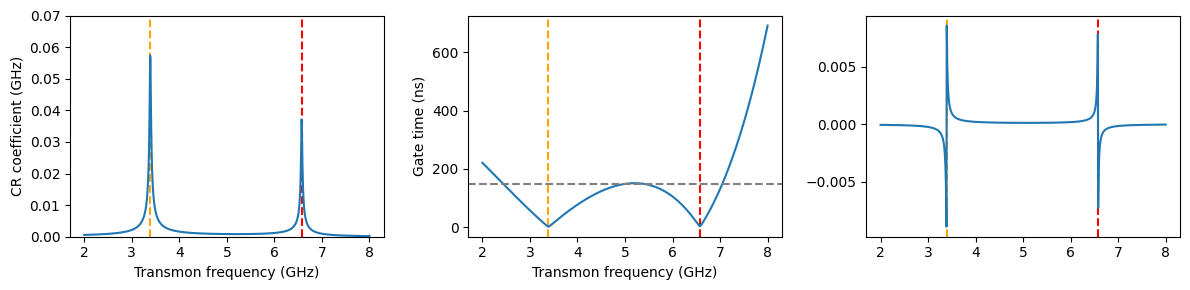

In [11]:
SAVE_IMAGE = False
FLUXONIUM_FREQ_12 = 3.38858656
FLUXONIUM_FREQ_03 = 6.57448847

fig, (cr_ax, time_ax, zz_ax) = plt.subplots(ncols=3, figsize=(12, 3), dpi=100)


cr_ax.axvline(FLUXONIUM_FREQ_12, linestyle="--", color="orange")
cr_ax.axvline(FLUXONIUM_FREQ_03, linestyle="--", color="red")

cr_ax.plot(
    transmon_scan_arr.transmon_freq, 
    transmon_scan_arr.sel(param="mu_yz_coeff")
)

cr_ax.set_ylim(0, 0.07)
cr_ax.set_xlabel("Transmon frequency (GHz)")
cr_ax.set_ylabel("CR coefficient (GHz)")

time_ax.axvline(FLUXONIUM_FREQ_12, linestyle="--", color="orange")
time_ax.axvline(FLUXONIUM_FREQ_03, linestyle="--", color="red")

time_ax.plot(
    transmon_scan_arr.transmon_freq, 
    1/(8*transmon_scan_arr.sel(param="mu_yz_coeff"))
) 

time_ax.axhline(150, linestyle="--", color="grey")
time_ax.set_xlabel("Transmon frequency (GHz)")
time_ax.set_ylabel("Gate time (ns)")

zz_ax.axvline(FLUXONIUM_FREQ_12, linestyle="--", color="orange")
zz_ax.axvline(FLUXONIUM_FREQ_03, linestyle="--", color="red")

zz_ax.plot(
    transmon_scan_arr.transmon_freq, 
    transmon_scan_arr.sel(param="zz_coeff")
) 

plt.tight_layout()
plt.show()

# Zooming into regions of interest

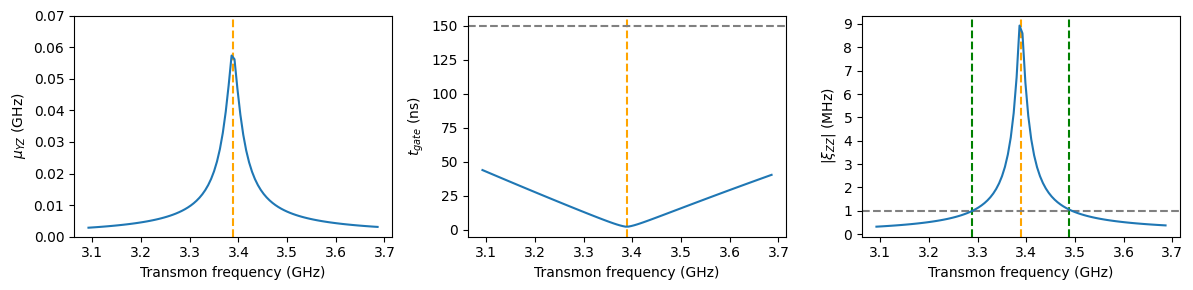

In [12]:
SAVE_IMAGE = False
FLUXONIUM_FREQ_12 = 3.38858656
FLUXONIUM_FREQ_03 = 6.57448847

MAX_FREQ = FLUXONIUM_FREQ_12 + 0.3
MIN_FREQ = FLUXONIUM_FREQ_12 - 0.3

trunc_arr = transmon_scan_arr.where(transmon_scan_arr.transmon_freq < MAX_FREQ, drop=True)
trunc_arr = trunc_arr.where(trunc_arr.transmon_freq > MIN_FREQ, drop=True) 

fig, (cr_ax, time_ax, zz_ax) = plt.subplots(ncols=3, figsize=(12, 3), dpi=100)

cr_ax.axvline(FLUXONIUM_FREQ_12, linestyle="--", color="orange")
#cr_ax.axvline(FLUXONIUM_FREQ_03, linestyle="--", color="red")

cr_ax.plot(
    trunc_arr.transmon_freq, 
    trunc_arr.sel(param="mu_yz_coeff")
)

cr_ax.set_ylim(0, 0.07)
cr_ax.set_xlabel("Transmon frequency (GHz)")
cr_ax.set_ylabel("$\mu_{YZ}$ (GHz)")

time_ax.axvline(FLUXONIUM_FREQ_12, linestyle="--", color="orange")
#time_ax.axvline(FLUXONIUM_FREQ_03, linestyle="--", color="red")

time_ax.plot(
    trunc_arr.transmon_freq, 
    1/(8*trunc_arr.sel(param="mu_yz_coeff"))
) 

time_ax.axhline(150, linestyle="--", color="grey")
time_ax.set_xlabel("Transmon frequency (GHz)")
time_ax.set_ylabel(r"$t_{gate}$ (ns)")

zz_ax.axvline(FLUXONIUM_FREQ_12, linestyle="--", color="orange")
#zz_ax.axvline(FLUXONIUM_FREQ_03, linestyle="--", color="red")
zz_ax.axvline(FLUXONIUM_FREQ_12 - 0.1, linestyle="--", color="green")
zz_ax.axvline(FLUXONIUM_FREQ_12 + 0.1, linestyle="--", color="green")
zz_ax.axhline(1, linestyle="--", color="grey")

zz_ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
zz_ax.set_xlabel("Transmon frequency (GHz)")
zz_ax.set_ylabel(r"$\left|\xi_{ZZ} \right|$ (MHz)")

zz_ax.plot(
    trunc_arr.transmon_freq, 
    np.abs(trunc_arr.sel(param="zz_coeff")*1e3)
) 

plt.tight_layout()
plt.show()

In [132]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"transmon_fluxonium_param_scan_transmon_freq.nc"
    result_arr.to_netcdf(data_folder/data_arr_name)

# Fluxonium paramters scan

In [39]:
NUM_INDUCT_ENERGIES = 201
INDUCT_ENERGIES = np.linspace(0.5, 1.5, NUM_INDUCT_ENERGIES)

NUM_JOSEPH_ENERGIES = 201
JOSEPH_ENERGIES = np.linspace(2, 10, NUM_JOSEPH_ENERGIES)

In [ ]:
LOAD_DATA = False

if LOAD_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"transmon_fluxonium_param_scan_joseph_induct_energy.nc"
    fluxonium_scan_arr = xr.load_dataarray(data_folder/data_arr_name)
else:
    results = np.zeros((NUM_INDUCT_ENERGIES, NUM_JOSEPH_ENERGIES, 12), dtype=float)

    for i, joseph_energy in enumerate(JOSEPH_ENERGIES):
        for j, induct_energy in enumerate(INDUCT_ENERGIES):
            fluxonium = qubits.Fluxonium(
                label='fluxonium', 
                charge_energy=PARAMS["charge_energy_f"], 
                induct_energy=induct_energy, 
                joseph_energy=joseph_energy,
                diel_loss_tan=PARAMS["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
                env_thermal_energy=thermal_energy,
                dephasing_times=PARAMS["dephasing_times_f"] #ns/2*np.pi 
            )
            fluxonium.diagonalize_basis(LEVELS_FLUXONIUM)

            params = extract_params(transmon, fluxonium, coup_coeff, eps_drive=0.6)
            results[i, j] = np.array(list(params.values()))  

    fluxonium_scan_arr = xr.DataArray(
        results,
        dims=["joseph_energy", "induct_energy", "param"],
        coords=dict(
            joseph_energy = JOSEPH_ENERGIES,
            induct_energy = INDUCTT_ENERGIES,
            param = ["transmon_freq_01", "transmon_freq_12", "transmon_freq_02", "fluxonium_freq_01", "fluxonium_freq_02", "fluxonium_freq_03", "fluxonium_freq_04", "fluxonium_freq_12", "fluxonium_freq_13", "fluxonium_freq_14", "mu_yz_coeff", "zz_coeff"]
        )
    )

In [15]:
SAVE_DATA = False

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"transmon_fluxonium_param_scan_joseph_induct_energy.nc"
    fluxonium_scan_arr.to_netcdf(data_folder/data_arr_name)

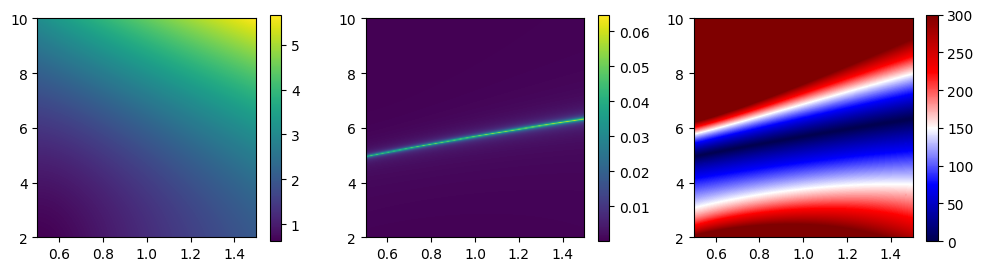

In [209]:
fig, axs = plt.subplots(ncols = 3, figsize=(12, 3), dpi=100)

induct_energies = fluxonium_scan_arr.induct_energy.values
joseph_energies = fluxonium_scan_arr.joseph_energy.values

extent = (induct_energies.min(), induct_energies.max(), joseph_energies.min(), joseph_energies.max())
aspect = (induct_energies.max() - induct_energies.min())/(joseph_energies.max() - joseph_energies.min())

img = axs[0].imshow(
    fluxonium_scan_arr.sel(param="fluxonium_freq_03") - fluxonium_scan_arr.sel(param="fluxonium_freq_12"),
    extent=extent,
    aspect=aspect,
    interpolation="gaussian"
)
plt.colorbar(img, ax=axs[0])

img = axs[1].imshow(
    fluxonium_scan_arr.sel(param="mu_yz_coeff"),
    origin="lower",
    extent=extent,
    aspect=aspect,
    interpolation="gaussian"
)
plt.colorbar(img, ax=axs[1])

img = axs[2].imshow(
    1 / (8*fluxonium_scan_arr.sel(param="mu_yz_coeff")),
    origin="lower",
    extent=extent,
    aspect=aspect,
    interpolation="gaussian",
    vmin=0,
    vmax=300,
    cmap="seismic"

)
plt.colorbar(img, ax=axs[2])


plt.show()

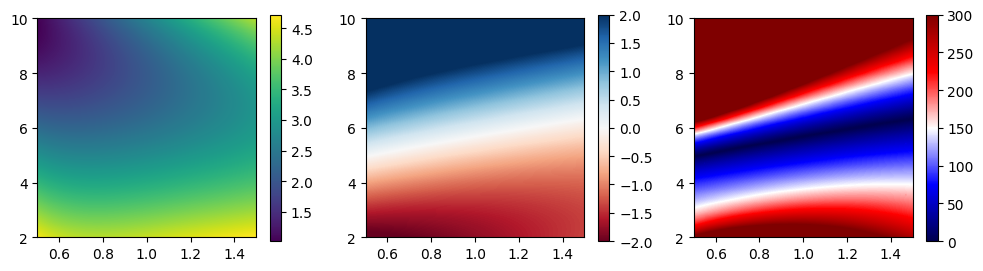

In [227]:
fig, axs = plt.subplots(ncols = 3, figsize=(12, 3), dpi=100)

induct_energies = fluxonium_scan_arr.induct_energy.values
joseph_energies = fluxonium_scan_arr.joseph_energy.values

extent = (induct_energies.min(), induct_energies.max(), joseph_energies.min(), joseph_energies.max())
aspect = (induct_energies.max() - induct_energies.min())/(joseph_energies.max() - joseph_energies.min())

img = axs[0].imshow(
    fluxonium_scan_arr.sel(param="fluxonium_freq_03") - fluxonium_scan_arr.sel(param="transmon_freq_01"),
    extent=extent,
    aspect=aspect,
)

plt.colorbar(img, ax=axs[0])

img = axs[1].imshow(
    fluxonium_scan_arr.sel(param="fluxonium_freq_12") - fluxonium_scan_arr.sel(param="transmon_freq_01"),
    origin="lower",
    extent=extent,
    aspect=aspect,
    vmin=-2,
    vmax=2,
    cmap="RdBu"
)
plt.colorbar(img, ax=axs[1])

img = axs[2].imshow(
    1 / (8*fluxonium_scan_arr.sel(param="mu_yz_coeff")),
    origin="lower",
    extent=extent,
    aspect=aspect,
    vmin=0,
    vmax=300,
    cmap="seismic"

)
plt.colorbar(img, ax=axs[2])


plt.show()

In [23]:
flx = qubits.Fluxonium(
    "test",
    charge_energy=1,
    induct_energy=0.5,
    joseph_energy=7.99,
)
flx.diagonalize_basis(5)
elvls = flx.eig_energies()
print(elvls[1] - elvls[0])
print(flx.state("1")[0] - flx.state("0")[0])

0.03023356068459271
0.03023356068459271


In [29]:
fluxonium_scan_arr[149, 0].sel(param="fluxonium_freq_01")

<xarray.DataArray ()>
array(0.42367775)
Coordinates:
    joseph_energy  float64 7.99
    induct_energy  float64 0.5
    param          <U17 'fluxonium_freq_01'

# Scan in expected variation range

In [152]:
MAX_RESIST_STD = 10e-2
MAX_RESIST_OFFSET = 5 * MAX_RESIST_STD # Corresponding to 4 sigmas from the gaussian distribtuion

NUM_POINTS = 101
RESIST_OFFSETS = np.linspace(-MAX_RESIST_OFFSET, MAX_RESIST_OFFSET, NUM_POINTS)

In [153]:
TRANSMON_TARGET_FREQ = 4.4
FREQ_OFFSETS = 0.5 * RESIST_OFFSETS * TRANSMON_TARGET_FREQ

TARGET_JOSEPH_ENERGY = PARAMS["joseph_energy_f"]
JOSEPH_ENERGY_OFFSETS = RESIST_OFFSETS * TARGET_JOSEPH_ENERGY

TARGET_INDUCT_ENERGY = PARAMS["induct_energy_f"]
NUM_JUNCTIONS = 100
INDUCT_ENERGY_OFFSETS = RESIST_OFFSETS * TARGET_INDUCT_ENERGY / np.sqrt(NUM_JUNCTIONS)

# Previous single parameter scans

In [6]:
induct_energy = PARAMS["induct_energy_f"]
energy_offsets = np.linspace(-induct_energy*1e-1, induct_energy*1e-1, 100)

results = defaultdict(list)
for offset in energy_offsets:
    fluxonium.induct_energy = induct_energy + offset
    trans_freqs = extract_trans_freqs(transmon, fluxonium)
    for freq_label, freq_val in trans_freqs.items():
        results[freq_label].append(freq_val)

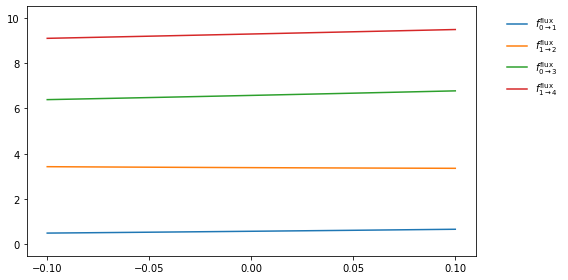

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
for freq_key in results.keys():
    qubit_label, _, level_i, level_j = freq_key.split("_")
    if qubit_label == "fluxonium":
        label = f"$f^{{\mathrm{{flux}}}}_{{{level_i} \\rightarrow {level_j}}}$"
        ax.plot(energy_offsets / induct_energy, results[freq_key], label=label)
    
    
ax.set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylim(-0.5, 10.5)
plt.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
)
plt.tight_layout()
plt.show()

In [8]:
joseph_energy = PARAMS["joseph_energy_f"]
energy_offsets = np.linspace(-induct_energy*2e-1, induct_energy*2e-1, 100)

results = defaultdict(list)
for offset in energy_offsets:
    fluxonium.joseph_energy = joseph_energy + offset
    trans_freqs = extract_trans_freqs(transmon, fluxonium)
    for freq_label, freq_val in trans_freqs.items():
        results[freq_label].append(freq_val)

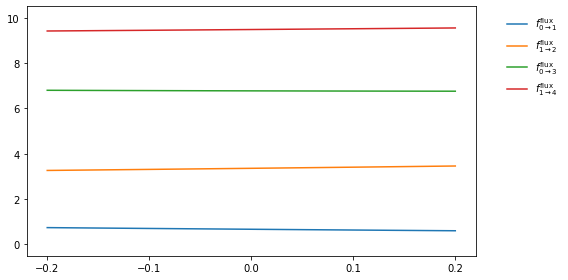

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
for freq_key in results.keys():
    qubit_label, _, level_i, level_j = freq_key.split("_")
    if qubit_label == "fluxonium":
        label = f"$f^{{\mathrm{{flux}}}}_{{{level_i} \\rightarrow {level_j}}}$"
        ax.plot(energy_offsets / induct_energy, results[freq_key], label=label)
    
    
ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylim(-0.5, 10.5)
plt.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
)
plt.tight_layout()
plt.show()